In [76]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('..')

from src.model import DeepCleanAutoencoder
from src.dataset import GWDataset
from src.utils import postprocess

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on device: {device}")

Running on device: cuda


### Config

In [ ]:
MODEL_PATH = '../models/best_model.pth'
TEST_DATA_PATH = '../data/paper_data.npz' 

# match training
LINEAR = True
SAMPLE_RATE = 2048
BAND_MIN = 80.0      # Target 60Hz mains
BAND_MAX = 1000.0

INFERENCE_OVERLAP = 4.0

### Load Data and Model

In [ ]:
data = np.load(TEST_DATA_PATH)
strain_raw = data['strain']
witnesses_raw = data['witnesses']

print(f"Strain Shape: {strain_raw.shape}")
print(f"Witnesses Shape: {witnesses_raw.shape}")

test_dataset = GWDataset(
    strain_raw, 
    witnesses_raw, 
    SAMPLE_RATE, 
    overlap=INFERENCE_OVERLAP, 
    band_start=BAND_MIN, 
    band_end=BAND_MAX,
    linear=LINEAR
)

model = DeepCleanAutoencoder(num_witnesses=witnesses_raw.shape[0]).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("Model loaded")

Strain Shape: (4194304,)
Witnesses Shape: (1, 4194304)


RuntimeError: Error(s) in loading state_dict for DeepCleanAutoencoder:
	size mismatch for in_conv.0.weight: copying a param with shape torch.Size([8, 4, 7]) from checkpoint, the shape in current model is torch.Size([8, 1, 7]).

In [79]:
for key in data.keys():
    print(key)
    print(data[key])

strain
[3.96706703e-19 4.13418689e-19 4.21688583e-19 ... 4.96854866e-19
 4.92270205e-19 4.77331058e-19]
witnesses
[[-2.04561058e-20  1.02828562e-20  5.33143334e-21 ...
  -2.91271757e-20 -1.30589199e-20 -6.41665388e-21]]
times
[1.18241077e+09 1.18241077e+09 1.18241077e+09 ... 1.18241179e+09
 1.18241179e+09 1.18241179e+09]
sample_rate
4096
gps_start
1182410770
duration
1024
detector
H1
witness_channels
['MOCK:WITNESS']
ts_object
[3.96706703e-19 4.13418689e-19 4.21688583e-19 ... 4.96854866e-19
 4.92270205e-19 4.77331058e-19]


### Run Inference + post process stuff

In [80]:
segment_idx = 0

w_tensor, h_tensor_norm = test_dataset[segment_idx]

w_batch = w_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    pred_normalized = model(w_batch)

noise_estimate = postprocess(
    pred_normalized, 
    test_dataset.strain_mean, 
    test_dataset.strain_std, 
    SAMPLE_RATE, 
    BAND_MIN, 
    BAND_MAX
)

start_idx = test_dataset.indices[segment_idx]
end_idx = start_idx + test_dataset.seg_len

segment_original = strain_raw[start_idx:end_idx]
segment_cleaned = segment_original - noise_estimate

print(f"Processed Segment {segment_idx} (Time: {start_idx/SAMPLE_RATE:.1f}s - {end_idx/SAMPLE_RATE:.1f}s)")

Processed Segment 0 (Time: 0.0s - 8.0s)


### Actual visualization stuff i dont feel like doing

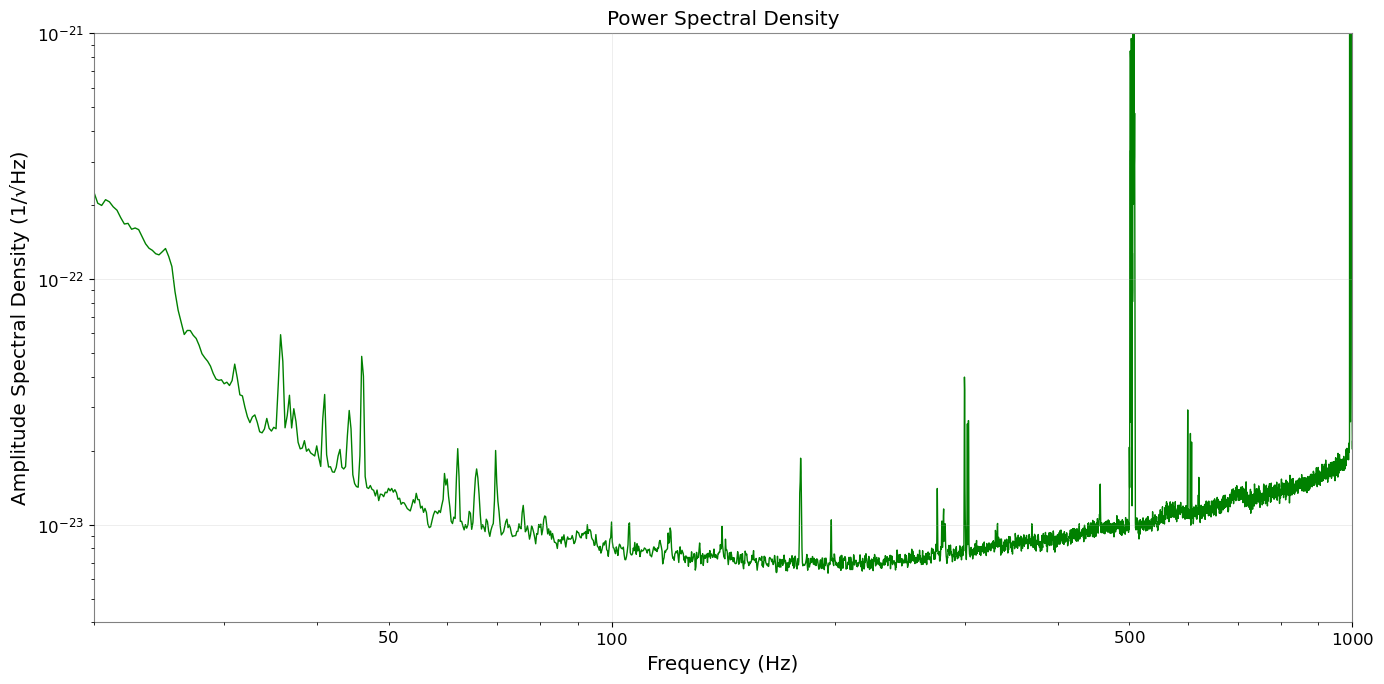

In [85]:
segment_original

from gwpy.timeseries import TimeSeries


def visualize_data(data):
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(1, 1, figsize=(14, 7))

    # 3. Power Spectral Density (PSD)
    psd = data.psd(fftlength=4, overlap=1)
    axes.loglog(psd.frequencies.value, np.sqrt(psd.value), 'g-', linewidth=1)
    axes.set_xlabel('Frequency (Hz)')
    axes.set_ylabel('Amplitude Spectral Density (1/√Hz)')
    axes.set_title('Power Spectral Density')
    axes.set_xlim(20, 1e3)
    axes.set_ylim(4e-24, 1e-21)
    axes.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

dataTS = TimeSeries(data['strain'], unit = 's', t0 = data['gps_start'], dt = 1 / data['sample_rate'])
visualize_data(dataTS)